I will implement a gated recurrent unit with an attention layer. The architecture is as described by equations (10.1) to (10.4) in my note on stability.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import random

In [46]:
# Helper functions
def get_random_weights(n):
    """Generate n random numbers whose total is 1."""
    R = random.sample(range(1, 11), n)
    return np.array([r/sum(R) for r in R])


def get_random_points(radius, n):
    """Generate n random points on a circle of given radius centred at the origin."""
    W = get_random_weights(n)
    points = [[radius*np.cos(2*np.pi*w), radius*np.sin(2*np.pi*w)] for w in W]
    
    return points

def list_mul_2d(M, m):
    """ M is a list of lists. Multiply each one of them by m."""
    return [[m * x for x in L] for L in M]

def eu_dist(x1, x2):
    """Euclidean distance between points x1 and x2 in R^n."""   
    return np.linalg.norm(x1 - x2)

def get_distance(x_init, xs):
    return [eu_dist(x_init, x) for x in xs]


In [47]:
Wh = np.array([get_random_weights(3)])
AWv = np.array([get_random_weights(2)])
# Initial points on a small circle of radius 0.01.
r = 0.01
N = 10
x_inits = [[r*np.cos(2*n*np.pi/N), r*np.sin(2*n*np.pi/N)] for n in range(1, N + 1)]

# Build 4 x 3 weight matrix
w1 = get_random_weights(4)
w2 = get_random_weights(4)
w3 = get_random_weights(4)
W = np.matrix([w1, w2, w3]).T

In [118]:
def f(h, t, U, extra = 0):  
    v = np.matmul(U, h)
    v0 = v[0]
    v1 = v[1]
    [x, y] = h
    
    xdot = 0.5*(np.tanh(v0) - x)
    ydot = 0.5*(np.tanh(v1) - y)
    
    return [xdot, ydot]

def get_HW(x, Wh):
    H = np.matrix([x, x, x]).T
    return np.matmul(H, Wh.T)

def get_Ml(x, Wh, AWv):
    hw = np.array(get_HW(x, Wh))
    X = np.concatenate((hw, AWv.T), axis=None)
    return np.tanh(X)

def get_a(W, Ml):
    args = np.exp([np.matrix(Ml) @ W[:, i] for i in range(W.shape[1])])   
    return args/np.sum(args)

def get_y(x, Wh, AWv, W):
    Ml = get_Ml(x, Wh, AWv)
    a = get_a(W, Ml)
    H = np.matrix([x, x, x])
    return H.T @ a.flatten()

In [119]:
def solve(U, x_init):    
    times = np.linspace(0, 500, 2000)  
    xs = odeint(f, x_init, times, args = (U, 0))
    
    return xs

In [122]:
def aluint(x_init, times, U):
    xs = odeint(f, x_init, times, args = (U, 0))  
    ys = np.array([get_y(xs[i, :], Wh, AWv, W) for i in range(xs.shape[0])])
    ys = np.concatenate(ys, axis=0)
    
    return (xs, ys)

In [125]:
# U = 3 * np.eye(2)
U = np.array([[0.1, -0.1],[-1, 0]])
times = np.linspace(0, 500, 2000)
xs = solve(U, [0.5, 0.5])
ignore, ys = aluint([0.5, 0.5], times, U)

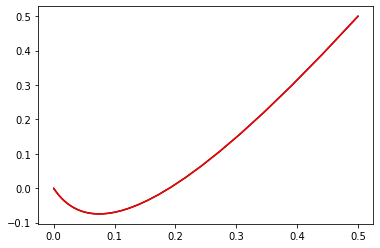

In [126]:
plt.plot(xs[:,0], xs[:,1], '-', color = 'black')
plt.plot(ys[:,0], ys[:,1], '-', color = 'red')

In [127]:
np.sum(xs - ys)

-2.489584123927085e-16